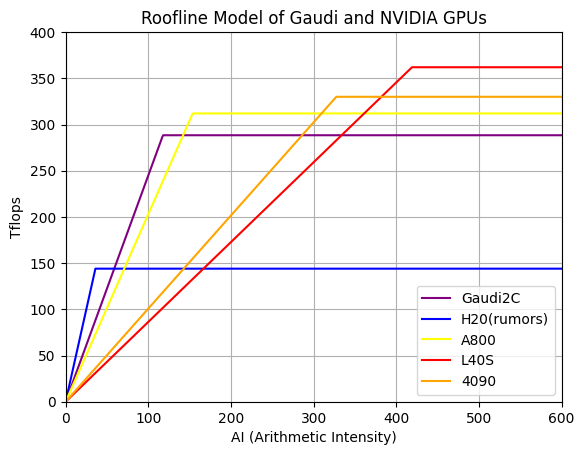

In [1]:
import matplotlib.pyplot as plt

def plot_roofline(peak_performance, memory_bandwidth, color, label):
    # peak perf TFlops, mem bandwidth TB/s
    coef = peak_performance / memory_bandwidth
    ai_intevals = range(1000)
    # ai_values = coef * ai_intevals
    tflops_values = [min(i * memory_bandwidth, peak_performance) for i in ai_intevals]

    plt.plot(ai_intevals, tflops_values, color=color, label = label)

# A100
peak_performance = 312
memory_bandwidth = 2.039

plot_roofline(peak_performance, memory_bandwidth, 'purple', "A100")


# H20
peak_performance = 144  
memory_bandwidth = 4.0

# 绘制 Roofline 曲线
plot_roofline(peak_performance, memory_bandwidth, 'blue', "H20(rumors)")

# H20
peak_performance = 312  # Tflops
memory_bandwidth = 2.03   # TB/s

plot_roofline(peak_performance, memory_bandwidth, 'yellow', "A800")

# L40
peak_performance = 362 
memory_bandwidth = 0.864  
plot_roofline(peak_performance, memory_bandwidth, 'red', "L40S")


# 4090
peak_performance = 330  
memory_bandwidth = 1.008 

plot_roofline(peak_performance, memory_bandwidth, 'orange', "4090")

plt.xlim(0, 600)
plt.ylim(0, 400) 

plt.xlabel('AI (Arithmetic Intensity)')
plt.ylabel('Tflops')
plt.title('Roofline Model of Gaudi and NVIDIA GPUs')

plt.grid(True)
plt.legend()
plt.show()

In [10]:
# Decoding AI calculation
# FP16 = 16B
HEAD=52
# llama 30B 6656, llama 7B 4096
DIM=6656 
# batch * seqlen
SEQLEN=512
BATCH=2
ELEM_SIZE = 16

# scale with batch size
def cal_QKV_GEMV_AI(dim, batch):
    return batch * (2 * dim ** 2) / (dim ** 2 + dim * 2) / ELEM_SIZE
def calc_FFN1_GEMV_AI(dim, batch):
    return batch * (2 * dim * dim * 4) / (dim * 4 * dim + dim*4 + dim) / ELEM_SIZE
def calc_FFN2_GEMV_AI(dim, batch):
    return batch * (2 * dim * dim * 4) / (dim * 4 * dim + dim*4 + dim) / ELEM_SIZE
    
# between transpose softmax
def calc_Attn1_GEMV_AI(head, dim, seqlen):
    #head, dimension, seqlen
    return (2 * dim / head * seqlen)/(dim / head + seqlen * dim / head + seqlen) / ELEM_SIZE

def calc_Attn2_GEMV_AI(head, dim, seqlen):
    #head, dimension, seqlen
    return (2 * dim / head * seqlen) / (dim / head * seqlen + seqlen + dim/seqlen) / ELEM_SIZE
    



print('Q,K,V,out AI:', cal_QKV_GEMV_AI(dim = DIM, batch = BATCH))
print('Attn1 AI:', calc_Attn1_GEMV_AI(head = 32, dim = DIM, seqlen = SEQLEN))
print('Attn2 AI:', calc_Attn2_GEMV_AI(head = 32, dim = DIM, seqlen = SEQLEN))
print('FFN1 AI:', calc_FFN1_GEMV_AI(dim = DIM, batch = BATCH))
print('FFN2 AI:', calc_FFN2_GEMV_AI(dim = DIM, batch = BATCH))

Q,K,V,out AI: 0.249924902373085
Attn1 AI: 0.12416057304879868
Attn2 AI: 0.12438680259014585
FFN1 AI: 0.24995305869540727
FFN2 AI: 0.24995305869540727


In [11]:
# Prefill AI Calculation


# scale with batch size
def cal_QKV_GEMV_AI(dim, seqlen, batch):
    return (2 * dim ** 2 * seqlen) / (dim ** 2 + dim * seqlen * 2) / ELEM_SIZE
def calc_FFN1_GEMV_AI(dim, seqlen, batch):
    return (2 * dim * seqlen * dim * 4) / (dim * 4 * dim + dim * seqlen + dim*4*seqlen) / ELEM_SIZE
def calc_FFN2_GEMV_AI(dim, seqlen, batch):
    return (2 * dim * dim * 4 * seqlen) / (dim * 4 * dim + dim * seqlen * 2) / ELEM_SIZE


# between transpose softmax
def calc_Attn1_GEMV_AI(head, dim, seqlen):
    #head, dimension, seqlen
    return (2 * dim / head * seqlen * seqlen)/(2 * seqlen * dim / head + seqlen * seqlen) / ELEM_SIZE

def calc_Attn2_GEMV_AI(head, dim, seqlen):
    #head, dimension, seqlen
    return (2 * dim / head * seqlen * seqlen) / (2 * dim / head * seqlen + seqlen * seqlen) / ELEM_SIZE
    


print('Q,K,V,out AI:', cal_QKV_GEMV_AI(dim = DIM, seqlen = SEQLEN, batch = BATCH))
print('Attn1 AI:', calc_Attn1_GEMV_AI(head = HEAD, dim = DIM, seqlen = SEQLEN))
print('Attn2 AI:', calc_Attn2_GEMV_AI(head = HEAD, dim = DIM, seqlen = SEQLEN))
print('FFN1 AI:', calc_FFN1_GEMV_AI(dim = DIM, seqlen = SEQLEN, batch = BATCH))
print('FFN2 AI:', calc_FFN2_GEMV_AI(dim = DIM, seqlen = SEQLEN, batch = BATCH))

Q,K,V,out AI: 110.93333333333334
Attn1 AI: 10.666666666666666
Attn2 AI: 10.666666666666666
FFN1 AI: 116.7719298245614
FFN2 AI: 123.25925925925925
